# Activations et Initialisations

Dans ce cours, nous allons reprendre le modèle Fully Connected introduit dans le cours 5 sur les NLP et nous allons regarder le comportement des activations tout au long du réseau à l'initialisation de celui-ci. Ce cours est inspiré du cours d'Andrej Karpathy [Building makemore Part 3: Activations & Gradients, BatchNorm](https://www.youtube.com/watch?v=P6sfmUTpUmc&t=3892s&ab_channel=AndrejKarpathy).

On a pu voir que les réseaux de neurones ont des nombreux avantages : 
- Ils sont très flexibles et sont capables de résoudre de nombreux problèmes.
- Ils sont assez simple à implémenter  

Cependant (ça serait trop facile sinon), il est souvent assez complexe des les optimiser et en particulier si il s'agit de réseaux profonds. 

## Reprise du code

On reprend le code du notebook 3 du cours 5 sur les NLP.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('../05_NLP/prenoms.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

Pour des fins pédagogiques, nous l'allons pas utiliser le dataset et dataloader de pytorch. On veut évaluer le loss au début de notre entraînement après le premier batch. Dans l'ensemble c'est à peu près la même chose sauf que l'on prend un batch au hasard à chaque itération au lieu de parcourir l'ensemble du dataset à chaque epoch.

In [3]:
block_size = 3 # Contexte

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] 

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([180834, 3]) torch.Size([180834])
torch.Size([22852, 3]) torch.Size([22852])
torch.Size([22639, 3]) torch.Size([22639])


In [4]:
embed_dim=10 # Dimension de l'embedding de C
hidden_dim=200 # Dimension de la couche cachée

C = torch.randn((46, embed_dim))
W1 = torch.randn((block_size*embed_dim, hidden_dim))
b1 = torch.randn(hidden_dim)
W2 = torch.randn((hidden_dim, 46))
b2 = torch.randn(46)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [5]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # Permet de construire un mini-batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  
  # Forward
  Xb, Yb = Xtr[ix], Ytr[ix] 
  emb = C[Xb] 
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1 

  h = torch.tanh(hpreact) 
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, Yb)
  
  # Retropropagation
  for p in parameters:
    p.grad = None
  
  loss.backward()
  # Mise à jour des paramètres
  lr = 0.1 if i < 100000 else 0.01 # On descend le learning rate d'un facteur 10 après 100000 itérations
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 21.9772
  10000/ 200000: 2.9991
  20000/ 200000: 2.5258
  30000/ 200000: 1.9657
  40000/ 200000: 2.4326
  50000/ 200000: 1.7670
  60000/ 200000: 2.1324
  70000/ 200000: 2.4160
  80000/ 200000: 2.2237
  90000/ 200000: 2.3905
 100000/ 200000: 1.9304
 110000/ 200000: 2.1710
 120000/ 200000: 2.3444
 130000/ 200000: 2.0970
 140000/ 200000: 1.8623
 150000/ 200000: 1.9792
 160000/ 200000: 2.4602
 170000/ 200000: 2.0968
 180000/ 200000: 2.0466
 190000/ 200000: 2.3746


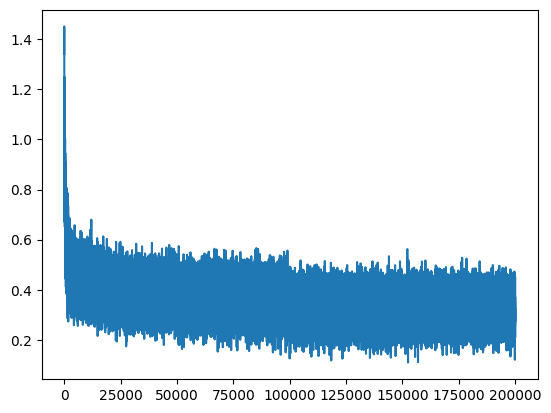

In [6]:
plt.plot(lossi)

Il y a beaucoup de "bruit" car on calcule à chaque fois le loss sur des petits batch par rapport à l'ensemble de nos données d'entraînement.

## Loss anormalement élévé à l'initialisation

L'entraînement se passe correctement. On peut cependant remarquer quelque chose de bizarre. Le loss au début de l'entraînement est anormalement élévé. On s'attendrait à avoir une valeur correspondant à un cas où chaque lettre a une probabilité uniforme d'apparation (donc $\frac{1}{46}$).   

Dans ce cas, on pourrait calculer le negative log likelihood et on obtiendrait :   
$-ln(\frac{1}{46})=3.83$   

Il serait donc logique de tomber sur une valeur de cet ordre là lors du premier calcul de notre loss. 

### Petit exemple illustrant le problème

Pour voir ce qu'il se passe, utilisons un petit exemple et regardons les valeurs de loss en fonction de l'initialisation. Imaginons que tous les poids dans logits sont initialisé à 0. Alors on aurait des probabilités uniformes

In [7]:
logits=torch.tensor([0.0,0.0,0.0,0.0])
probs=torch.softmax(logits,dim=0)
loss= -probs[1].log()
probs,loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

En revanche, il n'est pas conseillé d'initialiser les poids d'un réseau de neurones à 0. Ce que l'on avait fait, c'est une initialisation random basée sur une gaussienne centrée réduite.

In [8]:
logits=torch.randn(4)
probs=torch.softmax(logits,dim=0)
loss= -probs[1].log()
probs,loss

(tensor([0.3143, 0.0607, 0.3071, 0.3178]), tensor(2.8012))

On voit assez rapidement le problème, l'aléatoire de la gaussienne va faire pencher la balance d'un côté ou de l'autre (vous pouvez lancer plusieurs fois le code précédent pour vous en assurer).   
Mais alors, que peut-on faire ? Il suffit en fait de multiplier notre vecteur logit par une petite valeur pour diminuer la valeur initiale des poids et rendre le softmax plus uniforme.

In [9]:
logits=torch.randn(4)*0.01
probs=torch.softmax(logits,dim=0)
loss= -probs[1].log()
probs,loss

(tensor([0.2489, 0.2523, 0.2495, 0.2493]), tensor(1.3772))

On obtient, à peu de choses près, le même loss que pour des probabilités uniformes.

**Notes** : Par contre, on peut initialiser la valeur du biais à zéro car cela n'a pas de sens d'avoir un biais positif ou négatif à l'initialisation.

### Entraînement avec l'ajustement de l'initialisation

Reprenons le code précédent mais avec les nouvelles valeurs d'initialisation.

In [10]:
C = torch.randn((46, embed_dim))
W1 = torch.randn((block_size*embed_dim, hidden_dim))*0.01 # On initialise les poids à une petite valeur
b1 = torch.randn(hidden_dim) *0 # On initialise les biais à 0
W2 = torch.randn((hidden_dim, 46))*0.01
b2 = torch.randn(46)*0 
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [11]:
lossi = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] 
  emb = C[Xb] 
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1 
  h = torch.tanh(hpreact) 
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, Yb)
  
  for p in parameters:
    p.grad = None
  loss.backward()
  lr = 0.1 if i < 100000 else 0.01 
  for p in parameters:
    p.data += -lr * p.grad
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.8304
  10000/ 200000: 2.4283
  20000/ 200000: 2.0651
  30000/ 200000: 2.1124
  40000/ 200000: 2.3158
  50000/ 200000: 2.2752
  60000/ 200000: 2.1887
  70000/ 200000: 2.1783
  80000/ 200000: 1.8120
  90000/ 200000: 2.3178
 100000/ 200000: 2.0973
 110000/ 200000: 1.8992
 120000/ 200000: 1.6917
 130000/ 200000: 2.2747
 140000/ 200000: 1.8054
 150000/ 200000: 2.3569
 160000/ 200000: 2.4231
 170000/ 200000: 2.0711
 180000/ 200000: 2.1379
 190000/ 200000: 1.8419


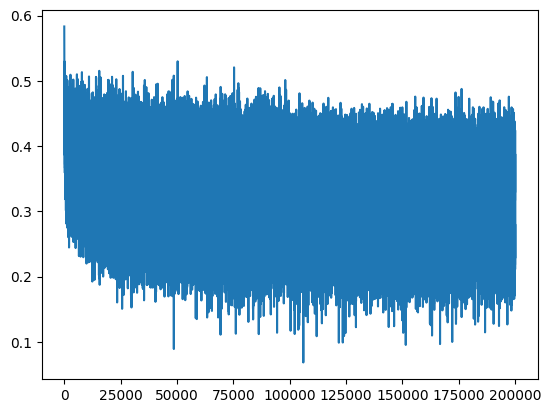

In [12]:
plt.plot(lossi)

On a maintenant une courbe de loss qui ne commence pas à une valeur aberrante, ce qui a pour effet d'accélerer l'optimisation. 

## Autre problème 

On peut se dire qu'un loss élévé n'est pas forcément un problème. Mais une mauvaise initialisation des poids peut poser d'autres problèmes.  
Considérons la première itération de l'entraînement avec des valeurs initialisée sans le facteur 0.01

In [13]:
C = torch.randn((46, embed_dim))
W1 = torch.randn((block_size*embed_dim, hidden_dim)) 
b1 = torch.randn(hidden_dim) 
W2 = torch.randn((hidden_dim, 46))
b2 = torch.randn(46)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [14]:
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix] 
emb = C[Xb] 
embcat = emb.view(emb.shape[0], -1)
hpreact = embcat @ W1 + b1 
h = torch.tanh(hpreact) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Yb)
  
for p in parameters:
  p.grad = None
loss.backward()

On regarde l'histogramme des valeurs après la fonction d'activation tanh.

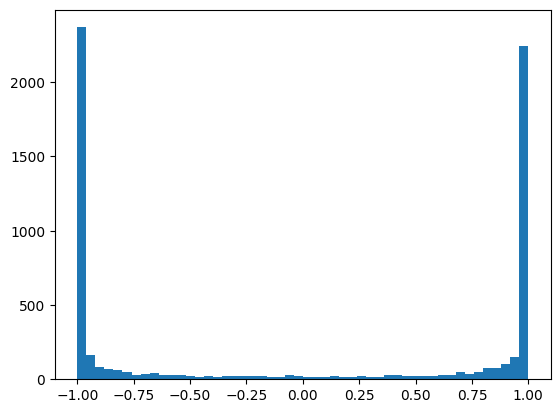

In [15]:
plt.hist(h.view(-1).tolist(),50);

On voit que la majorité des valeurs sont autour de 1 ou -1.  

En quoi cela pose t-il un problème ?   
Lors du calcul du gradient, avec la règle de la chaîne, on va multiplier les gradients des différentes étapes de calcul. La dérivée de la fonction tanH est :   
$tanh'(t)= 1 - t^2$   
Si les valeurs de t sont à 1 ou -1 alors le gradient va être extremement faible (jamais nul car c'est une asymptote) ce qui veut dire que le gradient ne se propage pas et donc l'optimization ne peut pas fonctionner de manière optimale au début de l'entraînement.   

On peut visualiser les valeurs de chaque neurone. 

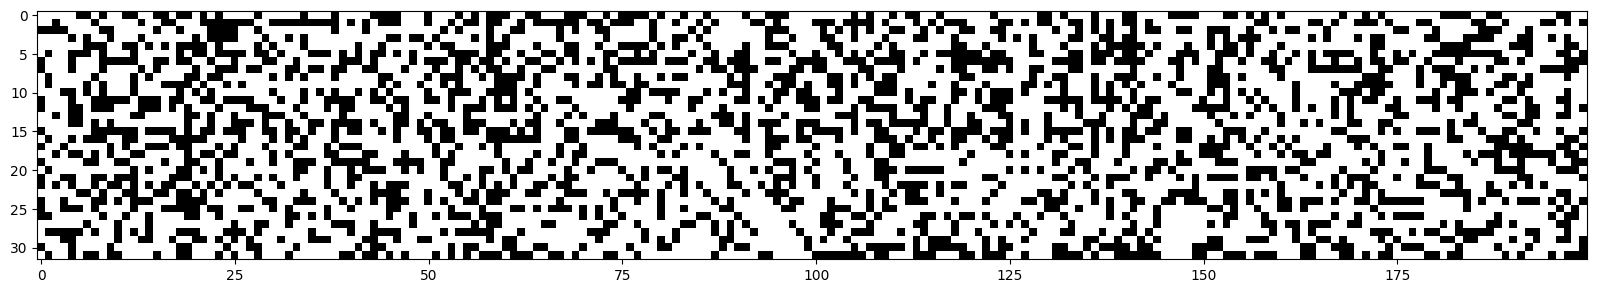

In [16]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

Chaque point blanc correspond à un neurone dont le gradient est à peu près égal à 0. 

**Neurone mort** : Si une de ces colonnes était entièrement blanche, cela voudrait dire que le neurone ne s'active sur aucun élément, ce qui signifie que c'est un neurone inutile, qui n'aura aucun impact sur le résultat et qu'on ne peut pas optimiser (sur les valeurs présentes dans ce batch).

**Notes** : 
- Ce type de comportement n'est pas exclusif à la tanh, la sigmoid et la ReLU peuvent avoir le même problème. 
- Le problème ne nous a pas empeché d'entraîner notre réseau correctement car il s'agit d'un petit modèle. Sur des réseaux plus profonds, c'est un gros problème et il est conseillé de vérifier les activations de votre réseau aux différentes étapes. 
- Les neurones morts peuvent arriver à l'initialisation mais aussi pendant l'entraînement si le learning rate est trop élévé par exemple. 

### Comment résoudre ce problème ?

Par chance, ce problème peut se résoudre exactement de la même manière que le problème du loss trop élévé. Pour nous en assurer, regardons les valeurs des activations et les neurones inactifs à l'initialisation avec nos nouvelles valeurs.

In [17]:
C = torch.randn((46, embed_dim))
W1 = torch.randn((block_size*embed_dim, hidden_dim)) *0.01# On initialise les poids à une petite valeur
b1 = torch.randn(hidden_dim) *0 # On initialise les biais à 0
W2 = torch.randn((hidden_dim, 46)) *0.01
b2 = torch.randn(46)*0 
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [18]:
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix] 
emb = C[Xb] 
embcat = emb.view(emb.shape[0], -1)
hpreact = embcat @ W1 + b1 
h = torch.tanh(hpreact) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Yb)
  
for p in parameters:
  p.grad = None
loss.backward()

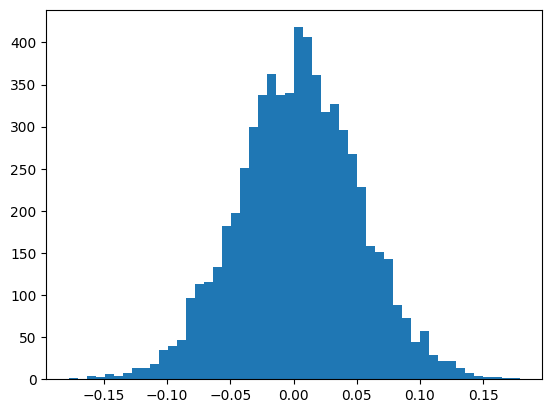

In [19]:
plt.hist(h.view(-1).tolist(),50);

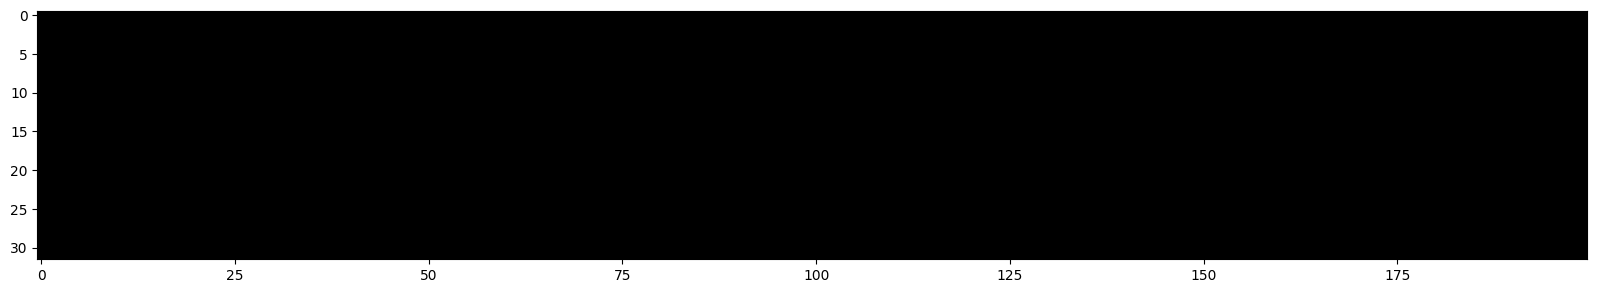

In [20]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

Tout va pour le mieux ! 

### Valeurs optimales à l'initialisation

Ce problème étant très important, de nombreuses recherches se sont dirigées sur ce sujet. Une publication notable est [Delving Deep into Rectifiers](https://arxiv.org/pdf/1502.01852) qui introduit la "Kaiming" initialization. Le papier propose des valeurs d'initialization pour chaque fonction d'activation qui font garantir une distribution centrée réduite sur l'ensemble du réseau.   
Cette méthode est implementée en [pytorch](https://pytorch.org/docs/stable/nn.init.html) et les couches que l'on va créer en pytorch sont directement initialisée de cette manière.

### Pourquoi ce cours est dans les bonus alors qu'il semble très important ?

Ce problème est en effet un problème majeur. Cependant, lorsque l'on utilise pytorch, tout est déjà initialisé de manière correcte et ce n'est en général pas nécessaire de modifier ces valeurs. 

De plus, de nombreuses méthodes ont été proposées pour diminuer ce problème, principalement :
- La batch norm, que nous verrons dans le notebook suivant, qui consiste à normaliser les valeurs avant l'activation tout le long du réseau.
- Les connexions résiduelles qui permettent de transmettre le gradient dans l'intégralité du réseau sans que celui-ci ne soit trop impacté par les fonctions d'activations.

Malgré l'importance de ces considérations, en pratique, il n'est pas forcément nécessaire d'être au courant pour entraîner un réseau de neurones.